In [1]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from neuralhydrology.modelzoo import get_model
from neuralhydrology.utils.config import Config
import matplotlib.pyplot as plt

from src.dynamics.nonlinear.lower_triangular.toy import ToyLowerTriangularNonlinearDynamics

device = "cuda" if torch.cuda.is_available() else "cpu"

# Set random seed for reproducibility
torch.manual_seed(42)

# Results settings
results_folder = os.path.join("results","toy","lstm")

figsize = (8, 6)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20  # Change this value to your desired font size

### Generate data ###

In [2]:
# Construct mappings that generate the data
dynamics_model_gt = ToyLowerTriangularNonlinearDynamics()

# Construct g
W_g = -torch.tensor([1., 0.75])
b_g = torch.tensor([-1.5])

In [3]:
# Construct dataset
N = 2500
i = torch.arange(N)
S = dynamics_model_gt.forward(i)
noise_level = 0.1

x_ = S[:,0:2] 
p_ = S[:,2:]
v_ = torch.nn.functional.softplus((W_g[None] * p_).sum(1) - b_g) 

# Add noise
x = x_ + noise_level * torch.randn_like(x_)
v = v_ + noise_level * torch.randn_like(v_)

# normalize
x_mean = x.mean(0)
x_std = x.std(0)
x = (x - x_mean) / x_std


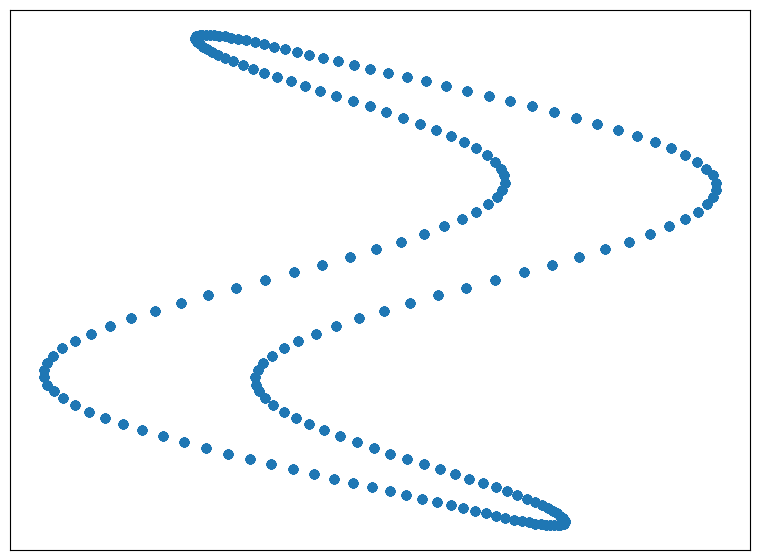

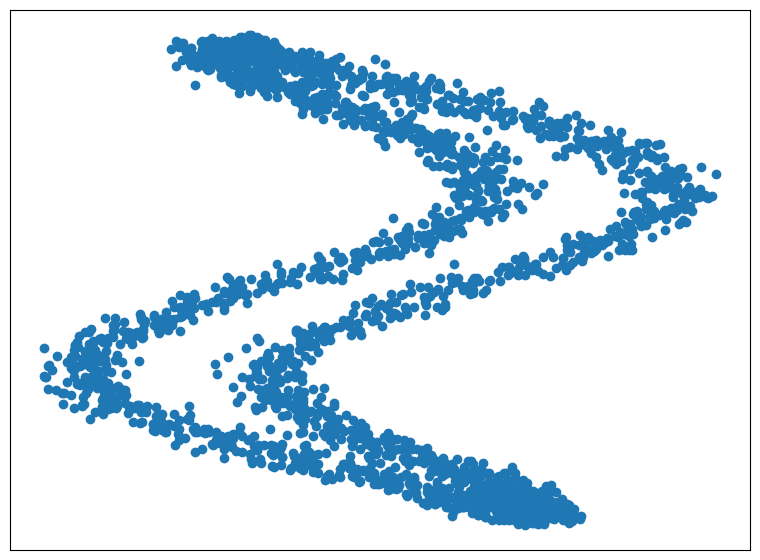

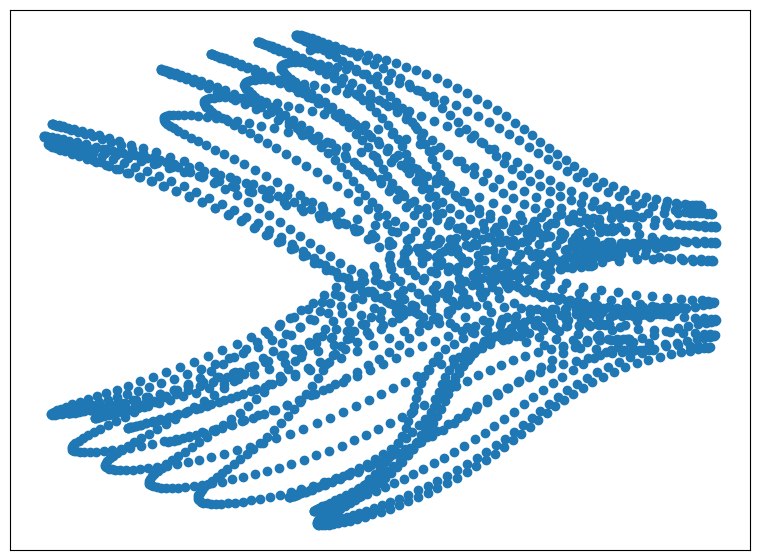

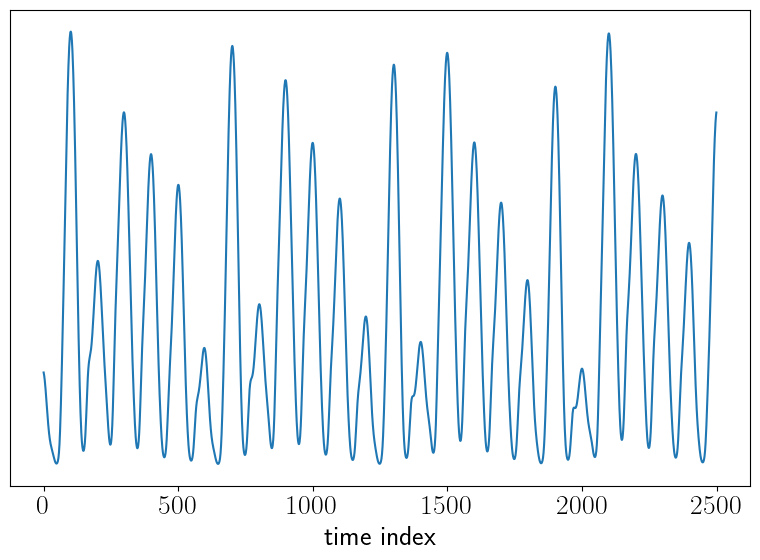

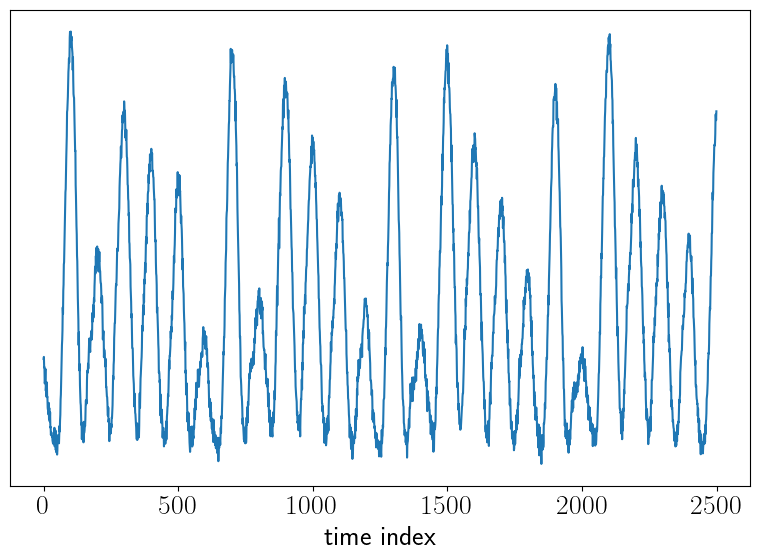

In [4]:
# Plot data dynamics
plt.figure(figsize=figsize)
plt.scatter(x_[:,0], x_[:,1])
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "x_data_clean.eps"))
plt.show()

# Plot data dynamics
plt.figure(figsize=figsize)
plt.scatter(x[:,0], x[:,1])
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "x_data.eps"))
plt.show()

# Plot latent dynamics
plt.figure(figsize=figsize)
plt.scatter(p_[:,0], p_[:,1])
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "p_data_clean.eps"))
plt.show()

# Plot signal
plt.figure(figsize=figsize)
plt.plot(i, v_)
plt.yticks([])  # Remove y-axis ticks
plt.xlabel("time index")
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "v_data_clean.eps"))
plt.show()

# Plot signal
plt.figure(figsize=figsize)
plt.plot(i, v)
plt.yticks([])  # Remove y-axis ticks
plt.xlabel("time index")
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "v_data.eps"))
plt.show()

In [5]:
# Split data into train and validation
split = 0.8
n_ = int(split * len(i))
i_train = i[:n_].float()
x_train = x[:n_].float()
v_train = v[:n_].float()
i_val = i[n_:].float()
x_val = x[n_:].float()
v_val = v[n_:].float()

### Reconstruct using LSTM ###

In [6]:
config = Config(
    {
    'validate_every': 3, # specify after how many epochs to perform validation
    'validate_n_random_basins': 1, # specify how many random basins to use for validation
    'metrics': ['NSE'], # specify which metrics to calculate during validation (see neuralhydrology.evaluation.metrics)
    # --- Model configuration --------------------------------------------------------------------------
    'model': 'cudalstm', # base model type [lstm, ealstm, cudalstm, embcudalstm, mtslstm]
    'head': 'regression', # prediction head [regression]. Define the head specific parameters below
    'dynamic_inputs': ['feature_1', 'feature_2'],  # Feature names
    'target_variables': ['discharge'],
    # ----> Regression settings <----
    'output_activation': 'linear',  
    # ----> General settings <----
    'hidden_size': 20, # Number of cell states of the LSTM
    'initial_forget_bias': 3, # Initial bias value of the forget gate
    'output_dropout': 0.4, # Dropout applied to the output of the LSTM
    # --- Training configuration -----------------------------------------------------------------------
    'optimizer': 'Adam', # specify optimizer [Adam]
    'loss': 'MSE', # specify loss [MSE, NSE, RMSE]
    'learning_rate': {0: 1e-2, 30: 5e-3, 40: 1e-3}, # specify learning rates to use starting at specific epochs (0 is the initial learning rate)
    'batch_size': 256, # Mini-batch size
    'epochs': 50, # Number of training epochs
    'clip_gradient_norm': 1, # If a value, clips the gradients during training to that norm.
    'predict_last_n': 1, # Defines which time steps are used to calculate the loss. Can't be larger than seq_length.
    'seq_length': 365, # Length of the input sequence
    'num_workers': 1, # Number of parallel workers used in the data pipeline
    'log_interval': 5, # Log the training loss every n steps
    'log_tensorboard': False, # If true, writes logging results into tensorboard file
    'log_n_figures': 0., # If a value and greater than 0, logs n random basins as figures during validation
    'save_weights_every': 1, # Save model weights every n epochs
    }
)

In [7]:
class HydrologyDataset(Dataset):
    def __init__(self, x, v, window_size):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.v = torch.tensor(v, dtype=torch.float32)
        self.window_size = window_size

    def __len__(self):
        return len(self.x) - self.window_size + 1

    def __getitem__(self, idx):
        return {'x_d': self.x[idx:idx+self.window_size], 'y': self.v[idx+self.window_size-1]}

# Create the dataset
train_dataset = HydrologyDataset(x_train, v_train, config.seq_length)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
test_dataset = HydrologyDataset(x, v, config.seq_length)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

/var/folders/ly/f4m8s6ks3w5cc8_y1dv124bc0000gn/T/ipykernel_3999/1078848358.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, dtype=torch.float32)
/var/folders/ly/f4m8s6ks3w5cc8_y1dv124bc0000gn/T/ipykernel_3999/1078848358.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.v = torch.tensor(v, dtype=torch.float32)


In [8]:
model = get_model(config).to(config.device)

In [9]:
from torch.optim.lr_scheduler import LambdaLR

# Extract initial learning rate from config dictionary
initial_lr = config.learning_rate[0]  # Get 1e-2 from {0: 1e-2, 30: 5e-3, 40: 1e-3}

# Create optimizer with initial learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)

# Implement custom learning rate schedule
def lr_lambda(epoch):
    for key in sorted(config.learning_rate.keys(), reverse=True):
        if epoch >= key:
            return config.learning_rate[key] / initial_lr
    return 1.0

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
criterion = torch.nn.MSELoss()

for epoch in range(config.epochs):
    model.train()
    for batch in train_loader:  # Use standard batch unpacking
        optimizer.zero_grad()
        
        # NeuralHydrology 1.7 expects dictionary-style inputs
        x_d = batch['x_d'].to(config.device).float()
        y_true = batch['y'][:,None].to(config.device).float()

        # Forward pass (model expects dictionary input in older versions)
        output = model(batch)
        loss = criterion(output['y_hat'][:,-1], y_true)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip_gradient_norm)
        optimizer.step()
    
    # Update learning rate according to schedule
    scheduler.step()
    
    print(f'Epoch {epoch+1}/{config.epochs} | Loss: {loss.item():.4f} | LR: {scheduler.get_last_lr()[0]:.5f}')


Epoch 1/50 | Loss: 3.6855 | LR: 0.01000
Epoch 2/50 | Loss: 3.8227 | LR: 0.01000
Epoch 3/50 | Loss: 3.2824 | LR: 0.01000
Epoch 4/50 | Loss: 2.4844 | LR: 0.01000
Epoch 5/50 | Loss: 1.6819 | LR: 0.01000
Epoch 6/50 | Loss: 2.3651 | LR: 0.01000
Epoch 7/50 | Loss: 1.7373 | LR: 0.01000
Epoch 8/50 | Loss: 1.3008 | LR: 0.01000
Epoch 9/50 | Loss: 1.3407 | LR: 0.01000
Epoch 10/50 | Loss: 1.4385 | LR: 0.01000
Epoch 11/50 | Loss: 1.4146 | LR: 0.01000
Epoch 12/50 | Loss: 0.9763 | LR: 0.01000
Epoch 13/50 | Loss: 0.9688 | LR: 0.01000
Epoch 14/50 | Loss: 1.0437 | LR: 0.01000
Epoch 15/50 | Loss: 0.7462 | LR: 0.01000
Epoch 16/50 | Loss: 0.9117 | LR: 0.01000
Epoch 17/50 | Loss: 1.1669 | LR: 0.01000
Epoch 18/50 | Loss: 0.9391 | LR: 0.01000
Epoch 19/50 | Loss: 0.9088 | LR: 0.01000
Epoch 20/50 | Loss: 0.6248 | LR: 0.01000
Epoch 21/50 | Loss: 0.9212 | LR: 0.01000
Epoch 22/50 | Loss: 0.7080 | LR: 0.01000
Epoch 23/50 | Loss: 0.8818 | LR: 0.01000
Epoch 24/50 | Loss: 0.7773 | LR: 0.01000
Epoch 25/50 | Loss: 0.993

In [10]:
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    
    with torch.no_grad():
        for batch in loader:
            
            output = model(batch)
            y_pred = output['y_hat'].cpu()
            
            all_preds.append(y_pred[:,-1])
    
    preds = torch.cat(all_preds).squeeze()
    return preds

# For test set (final evaluation)
v_net = torch.zeros_like(v)
v_net[config.seq_length-1:] = evaluate_model(model, test_loader)

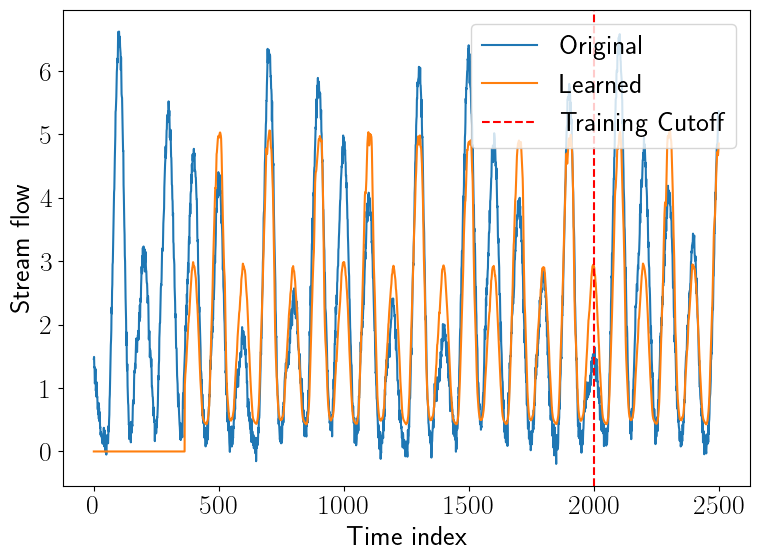

In [11]:
# Plot learned signal
plt.figure(figsize=figsize)
plt.plot(i, v, label='Original')
plt.plot(i, v_net, label='Learned')
plt.axvline(x=i_train[-1], color='r', linestyle='--', label='Training Cutoff')
plt.legend(loc='upper right')
plt.xlabel("Time index")
plt.ylabel("Stream flow")
plt.tight_layout()
plt.show()

In [12]:
# define NSE metric
def nse(original, predicted):
    
    if original.shape != predicted.shape:
        raise ValueError("Input tensors must have the same shape")
    
    mean_observed = torch.mean(original)
    numerator = torch.sum((original - predicted) ** 2)
    denominator = torch.sum((original - mean_observed) ** 2)

    return 1 - (numerator / denominator)

In [13]:
# Compute NSE metrics
total_nse = nse(v[config.seq_length-1:], v_net[config.seq_length-1:])

# Training NSE
train_nse = nse(v[config.seq_length-1:int(i_train[-1].item())+1], v_net[config.seq_length-1:int(i_train[-1].item())+1])

# Validation NSE
val_nse = nse(v[int(i_train[-1].item())+1:], v_net[int(i_train[-1].item())+1:])

print(f"Total NSE = {total_nse} | NSE on training data = {train_nse} | NSE on validation data = {val_nse}")

Total NSE = 0.7953371405601501 | NSE on training data = 0.7978231310844421 | NSE on validation data = 0.7863169312477112
